In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensornets as nets
from sklearn.metrics import confusion_matrix
import h5py
from tensorflow.python.framework import ops

## List of tasks:

1. Load images as arrays
2. Load labels
3. Convert labels from one-hot vector to vector of labels
4. Display images with labels
5. Flip images and labels
6. Make x and y training + dev arrays
7. Load pre-trained architecture (eg. VGG19)
8. Train with new data
9. Make predictions
10. Set up metrics - accuracy, precision, recall. Output train and dev metrics.
11. Tune hyperparameters

In [2]:
X_orig_file = 'X_final.npy'
X_orig = np.load(X_orig_file)

In [3]:
X_orig.shape

(11043, 224, 224, 3)

In [4]:
# Flip images and labels

m, n_H0, n_W0, n_C0 = X_orig.shape

In [5]:
labels_loc = 'Y_final_df.csv'
#Y_orig, labels = get_labels(labels_loc, m)
Y_df = pd.read_csv(labels_loc)
Y_orig = np.array(Y_df.iloc[:m, 1:])

In [6]:
def flip_arrs(X_orig, Y_orig):
    m, n_H0, n_W0, n_C0 = X_orig.shape
    X_flip = X_orig[:,:,n_W0-1::-1,:]
    Y_flip = Y_orig
    return X_flip, Y_flip

In [7]:
X_flip, Y_flip = flip_arrs(X_orig, Y_orig)

In [8]:
Y_flip.shape

(11043, 7)

In [9]:
X = np.vstack([X_orig, X_flip])
Y = np.vstack([Y_orig, Y_flip])

In [10]:
X.shape

(22086, 224, 224, 3)

In [11]:
Y.shape

(22086, 7)

In [12]:
# Make x and y training + dev arrays

def get_train_index(seed, train_size, m):
    np.random.seed(seed)
    train_index = np.random.choice(2*m, size = int(train_size*2*m), replace = False)
    dev_index = list(set(range(2*m)) - set(train_index))
    return train_index, dev_index


In [13]:
train_size = 0.9
seed = 3


In [14]:
train_index, dev_index = get_train_index(seed, train_size, m)

In [15]:
m_train = train_index.shape[0]

In [16]:
X_train = X[train_index]
Y_train = Y[train_index]

#X_train = np.empty([m_train, 224, 224, 3])
#Y_train = np.empty([m_train, 224, 224, 3])

#for i, j in enumerate(train_index):
#    X_train[i] = X[j]
#    Y_train[i] = Y[j]
X_dev = X[dev_index]
Y_dev = Y[dev_index]

In [17]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    # ImageNet input image shape is (244, 244, 3)
    inputs = tf.placeholder(tf.float32, [None, n_H0,n_W0,n_C0])

    # Output is dependent on your situation (10 for CIFAR-10)
    outputs = tf.placeholder(tf.float32, [None, n_y])
    return inputs, outputs

In [18]:
def forward_prop(model, inputs):

    # model to give the name
    if model == 'resnet50':
        logits = nets.ResNet50(inputs, is_training=True, classes=7)
        middles = logits.get_outputs()[-4]
    elif model == 'squeezenet':
        logits = nets.SqueezeNet(inputs, is_training=True, classes=7)
        middles = logits.get_outputs()[-3]

    Z1 = tf.contrib.layers.flatten(middles)
    # FULLY-CONNECTED 
    Z2 = tf.contrib.layers.fully_connected(Z1, 120)
    # FULLY-CONNECTED 
    Y_hat = tf.contrib.layers.fully_connected(Z2, 7, activation_fn = tf.nn.softmax)
    return Y_hat, logits

In [19]:

def compute_loss(outputs, Y_hat, class_weights):

    weights = tf.reduce_sum(class_weights * outputs, axis=1)

    # loss function applied to the last layer
    # train on the loss (Adam Optimizer is used)

    loss = tf.losses.softmax_cross_entropy(outputs, Y_hat)
    weighted_loss = tf.reduce_mean(loss*weights)
    return weighted_loss



def optimizer(learning_rate, weighted_loss):
    train = tf.train.AdamOptimizer(learning_rate).minimize(weighted_loss)
    return train



# for measuring accuracy after forward pass
def get_acc(Y_hat, outputs):
    predictions = tf.argmax(Y_hat, 1)
    correct_pred = tf.cast(tf.equal(predictions, tf.argmax(outputs, 1)),tf.float32)
    accuracy = tf.reduce_mean(correct_pred, name='accuracy')
    return prediction, accuracy

In [20]:
def train_model(X_train, Y_train, X_dev, Y_dev, model, class_weights, learning_rate, batch_size, num_epochs, print_loss = True):
    ops.reset_default_graph()
    n_y = Y_train.shape[1]
    m_train, n_H0, n_W0, n_C0 = X_train.shape
    num_batches = m_train//batch_size + 1
    
    losses = []
    inputs, outputs = create_placeholders(n_H0,n_W0,n_C0,n_y)
    Y_hat, logits = forward_prop(model, inputs)
    weighted_loss = compute_loss(outputs, Y_hat, class_weights)
    train = optimizer(learning_rate, weighted_loss)
    init = tf.global_variables_initializer()
    

    with tf.Session() as sess:    
        # Initializing the variables
        sess.run(init)

        # Loading the parameters
        sess.run(logits.pretrained())

        for epoch in range(num_epochs):
            batch_loss = 0
            full_batch = range(m_train)
            for batch in range(num_batches):
                try:
                    batch_index = np.random.choice(full_batch, size=batch_size, replace = False)
                    full_batch = np.array(list(set(full_batch) - set(batch_index)))
                except ValueError:
                    batch_index = full_batch
                X_train_batch = X_train[batch_index]
                Y_train_batch = Y_train[batch_index]
                sess.run(train, feed_dict = {inputs: X_train_batch, outputs: Y_train_batch})
                temp_loss = sess.run(weighted_loss, feed_dict ={inputs: X_train_batch, outputs: Y_train_batch})
                batch_loss += temp_loss/num_batches
            losses.append(batch_loss)
            if print_loss:
                print('Loss after epoch {:2d}: {:5f}'.format(epoch+1, batch_loss))
        
        predictions = tf.argmax(Y_hat, 1)  
        
        Y_train_preds = np.empty(shape = m_train)
        for batch in range(num_batches):
            if batch != num_batches - 1:
                batch_index = range(batch*batch_size, (batch+1)*batch_size)
            else:
                batch_index = range(batch*batch_size,m_train)
            X_train_batch = X_train[batch_index]
            Y_train_batch_preds = sess.run(predictions, feed_dict ={inputs: X_train_batch})
            Y_train_preds[batch_index] = Y_train_batch_preds
            #print('Train batch {} completed'.format(batch+1))
        
        
        m_dev = X_dev.shape[0]
        num_batches = m_dev//batch_size + 1
        
        Y_dev_preds = np.empty(shape = m_dev)
        for batch in range(num_batches):
            if batch != num_batches - 1:
                batch_index = range(batch*batch_size, (batch+1)*batch_size)
            else:
                batch_index = range(batch*batch_size,m_dev)
            X_dev_batch = X_dev[batch_index]
            Y_dev_batch_preds = sess.run(predictions, feed_dict ={inputs: X_dev_batch})
            Y_dev_preds[batch_index] = Y_dev_batch_preds
            #print('Dev batch {} completed'.format(batch+1))
        
        #Y_train_preds = get_preds(X_train, model, batch_size, sess)
        #Y_dev_preds = get_preds(X_dev, model, batch_size, sess)
    
    return Y_train_preds, Y_dev_preds, losses

In [21]:
model = 'resnet50'
class_weights = np.array(np.mean(Y_orig, axis = 0)).astype('float32')
learning_rate=2e-5
batch_size = 32
num_epochs = 12


Y_train_preds, Y_dev_preds, losses = train_model(X_train, Y_train, X_dev, Y_dev, model, class_weights, learning_rate, batch_size, num_epochs)

Loss after epoch  1: 0.617221
Loss after epoch  2: 0.604494
Loss after epoch  3: 0.573474
Loss after epoch  4: 0.546788
Loss after epoch  5: 0.533562
Loss after epoch  6: 0.525481
Loss after epoch  7: 0.518662
Loss after epoch  8: 0.513739
Loss after epoch  9: 0.509636
Loss after epoch 10: 0.506842
Loss after epoch 11: 0.491349
Loss after epoch 12: 0.479492


In [22]:
def plot_losses(model, losses, learning_rate):
    losses = np.squeeze(losses)
    num_epochs = len(losses)
    plot_title = "Learning rate =" + str(learning_rate)
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(losses)
    ax.set(title = plot_title, xlabel = 'Epochs', ylabel ='Loss', xlim = (-1,num_epochs+1))
    
    fig.savefig(model+'TrainingLoss.png')
    plt.show()

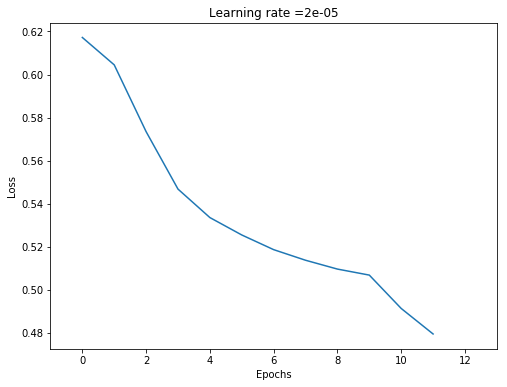

In [23]:
plot_losses(model, losses, learning_rate)

In [24]:
Y_train_vec = np.argmax(Y_train, 1)

In [25]:
Y_train_vec

array([1, 1, 0, ..., 1, 1, 1])

In [26]:
Y_train_preds

array([1., 1., 0., ..., 1., 1., 1.])

In [27]:
def get_metrics(actuals, preds):
    accuracy = np.mean((actuals == preds).astype(int))
    cm = confusion_matrix(actuals, preds)
    diag = np.diagonal(cm)
    vert_sum = np.sum(cm, axis = 0)
    hor_sum = np.sum(cm, axis = 1)
    precision = np.nanmean(diag/vert_sum)
    recall = np.nanmean(diag/hor_sum)
    f1score = 2*precision*recall/(precision+recall)
    
    metrics = {'accuracy': accuracy,'confusion_matrix': cm, 'precision':precision, 'recall': recall, 'f1score': f1score}
    return metrics

In [28]:
train_metrics = get_metrics(Y_train_vec, Y_train_preds)

In [29]:
train_metrics['accuracy']

0.9605071187805001

In [30]:
train_metrics['confusion_matrix']

array([[ 1567,   410,     3,     3,    12,     0,     2],
       [   24, 12018,    12,     5,    16,     0,     4],
       [    1,    24,   890,     1,     5,     0,     0],
       [    2,    20,     5,   548,    12,     0,     0],
       [   25,   140,     9,     7,  1801,     0,     0],
       [    1,    11,     0,     0,     4,  1020,     0],
       [    6,    20,     0,     0,     1,     0,  1248]])

In [31]:
train_metrics['precision']

0.9746511741812947

In [32]:
train_metrics['recall']

0.9359408508941417

In [33]:
Y_dev_vec = np.argmax(Y_dev, axis = 1)

In [34]:
Y_dev_vec

array([1, 1, 1, ..., 1, 2, 1])

In [35]:
dev_metrics = get_metrics(Y_dev_vec, Y_dev_preds)

In [36]:
dev_metrics['accuracy']

0.8886373924852875

In [37]:
dev_metrics['confusion_matrix']

array([[ 128,   91,    1,    1,    8,    0,    0],
       [   8, 1312,    3,    3,    4,    0,    1],
       [   2,   10,   82,    3,    9,    0,    1],
       [   3,    5,    4,   49,    6,    0,    0],
       [  24,   39,    3,    6,  144,    0,    0],
       [   0,    5,    0,    0,    1,  108,    0],
       [   2,    3,    0,    0,    0,    0,  140]])

In [38]:
dev_metrics['precision']

0.8795997159765742

In [39]:
dev_metrics['recall']

0.8031325338165695

In [44]:
learning_rate=3e-6
model = 'squeezenet'
Y_train_preds_sq, Y_dev_preds_sq, losses_sq = train_model(X_train, Y_train, X_dev, Y_dev, model, class_weights, learning_rate, batch_size, num_epochs=12)

Loss after epoch  1: 0.747425
Loss after epoch  2: 0.708969
Loss after epoch  3: 0.709248
Loss after epoch  4: 0.708905
Loss after epoch  5: 0.709061
Loss after epoch  6: 0.708927
Loss after epoch  7: 0.708529
Loss after epoch  8: 0.708742
Loss after epoch  9: 0.708647
Loss after epoch 10: 0.708848
Loss after epoch 11: 0.708583
Loss after epoch 12: 0.709196


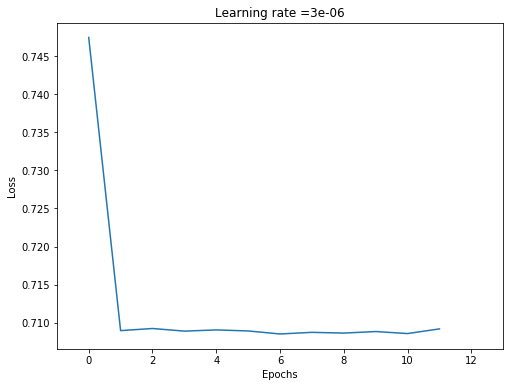

In [45]:
plot_losses(model, losses_sq, learning_rate)

In [46]:
train_metrics_sq = get_metrics(Y_train_vec, Y_train_preds_sq)

In [47]:
train_metrics_sq

{'accuracy': 0.6693293393243468,
 'confusion_matrix': array([[    0,  1990,     0,     0,     0,     0,     0],
        [    0, 12066,     0,     0,     0,     0,     0],
        [    0,   925,     0,     0,     0,     0,     0],
        [    0,   595,     0,     0,     0,     0,     0],
        [    0,  1986,     0,     0,     0,     0,     0],
        [    0,   211,     0,     0,     0,     0,     0],
        [    0,   254,     0,     0,     0,     0,     0]]),
 'precision': 0.6693293393243468,
 'recall': 0.14285714285714285}

In [48]:
dev_metrics_sq = get_metrics(Y_dev_vec, Y_dev_preds_sq)

In [49]:
dev_metrics_sq

{'accuracy': 0.670993509735397,
 'confusion_matrix': array([[   0,  236,    0,    0,    0,    0,    0],
        [   0, 1344,    0,    0,    0,    0,    0],
        [   0,  103,    0,    0,    0,    0,    0],
        [   0,   59,    0,    0,    0,    0,    0],
        [   0,  212,    0,    0,    0,    0,    0],
        [   0,   19,    0,    0,    0,    0,    0],
        [   0,   30,    0,    0,    0,    0,    0]]),
 'precision': 0.670993509735397,
 'recall': 0.14285714285714285}